# Traffic Prediction

## Data Description :
The dataset is stored in a CSV file and includes additional columns such as time in hours, date, days of the week, and counts for each vehicle type (CarCount, BikeCount, BusCount, TruckCount). 

The "Total" column represents the total count of all vehicle types detected within a 15-minute duration. 

The dataset is updated every 15 minutes, providing a comprehensive view of traffic patterns over the course of one month. 
The dataset includes a column indicating the traffic situation categorized into four classes: 
<ol>
        <li>Heavy</li>
        <li>High</li>
        <li>Normal </li>
        <li>Low</li>
        
        
</ol>

This information can help assess the severity of congestion and monitor traffic conditions at different times and days of the week.


## Importing Nesscary Libraries / Creating helping functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import mplcyberpunk


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import RocCurveDisplay


plt.style.use("cyberpunk")

In [2]:
import matplotlib.patches as mpatches

def plot_donut_chart(df: pd.DataFrame, column: str, ax: plt.Axes, title: str):
    
    pieData = pd.DataFrame(df[column].value_counts())

    labels = pieData.index.values

    sizes = pieData[column].values


    colors = ['#27dadf','#e968b6', '#d6bd1f', '#20df51']

    # Set width to 0.5 for both charts
    ax.pie(sizes, colors=colors, wedgeprops={'linewidth': 3, 'edgecolor': '#212946', 'width': 0.5})

    # Create a white circle at the center to turn the pie chart into a donut chart
    center_circle = plt.Circle((0, 0), 0.6, color='#212946')
    fig = ax.get_figure()
    fig.gca().add_artist(center_circle)
    
    percents = sizes * 100 / sizes.sum()
    labels = [f'{l}, {p:0.1f}%' for l, p in zip(labels, percents)]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
    
    ax.legend(handles=patches, bbox_to_anchor=(1.0, 1), loc='upper left')
    

    ax.set_title(title, fontsize=15)
    ax.set_aspect('equal')  # Set the aspect ratio to be equal

In [3]:
def convert24(time):
    # Parse the time string into a datetime object
    t = datetime.strptime(time, '%I:%M:%S %p')
    # Format the datetime object into a 24-hour time string
    return t.strftime('%H:%M:%S')


In [4]:
def Daytime(x):
    Hour = int(x[:2])
    if Hour>=5 and Hour <12: # Morning 
        return 1
    elif Hour >=12 and Hour <17: # AfterNoon
        return 2
    elif Hour>=17 and Hour<20: # Evening
        return 3
    else:                    # Night
        return 4


In [5]:
def DaytimeT(x):
    Hour = int(x[:2])
    if Hour>=5 and Hour <12: # Morning 
        return "Morning"
    elif Hour >=12 and Hour <17: # AfterNoon
        return "AfterNoon"
    elif Hour>=17 and Hour<20: # Evening
        return "Evening"
    else:                    # Night
        return "Night"


In [6]:
def BinningMonth(DayNumber):

    if DayNumber <= 7:
        return 1
    elif DayNumber > 7 and DayNumber <= 14:
        return 2
    elif DayNumber > 14 and DayNumber <= 21:
        return 3
    elif DayNumber > 21 and DayNumber <= 31:
        return 4

In [7]:
df = pd.read_csv(r"Traffic dataset.csv")
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [8]:
df.sort_values(by=["Date","Time"],inplace=True)
df.reset_index(drop=True,inplace=True)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,10:00:00 AM,1,Wednesday,97,2,16,7,122,normal
1,10:00:00 PM,1,Wednesday,17,4,0,36,57,normal
2,10:15:00 AM,1,Wednesday,22,8,31,8,69,normal
3,10:15:00 PM,1,Wednesday,16,1,1,29,47,normal
4,10:30:00 AM,1,Wednesday,31,23,19,12,85,normal
...,...,...,...,...,...,...,...,...,...
2971,9:15:00 PM,31,Tuesday,64,14,10,6,94,low
2972,9:30:00 AM,31,Tuesday,62,2,7,22,93,normal
2973,9:30:00 PM,31,Tuesday,71,14,17,10,112,normal
2974,9:45:00 AM,31,Tuesday,92,8,11,21,132,high


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


## Data Preprocessing

### Validating Total count in every Day

In [10]:
Validate = df.CarCount+df.BusCount+df.BikeCount+df.TruckCount

In [11]:
Validate = df.CarCount+df.BusCount+df.BikeCount+df.TruckCount

In [12]:
df[~(Validate==df.Total)]

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation


### Weekdays Encoding

In [13]:
week_day_dict = {
    'Sunday':1,
    'Monday':2,
    'Tuesday' : 3,
    'Wednesday' : 4,
    'Thursday' : 5,
    'Friday' : 6,
    'Saturday' :7
}

In [14]:
df['Day'] = df['Day of the week'].map(week_day_dict)
# df.drop("Day of the week",axis=1,inplace=True)

### Dealing with Time 

In [15]:
df["ModifiedTime"]=df.Time.apply(convert24)

In [16]:
df.ModifiedTime

0       10:00:00
1       22:00:00
2       10:15:00
3       22:15:00
4       10:30:00
          ...   
2971    21:15:00
2972    09:30:00
2973    21:30:00
2974    09:45:00
2975    21:45:00
Name: ModifiedTime, Length: 2976, dtype: object

In [17]:
df["DaytimeT"] = df.ModifiedTime.apply(DaytimeT)
df["Daytime"] = df.ModifiedTime.apply(Daytime)
df["MonthQuarter"] = df.Date.apply(BinningMonth)

In [18]:
df.sort_values(by=["Date","Daytime"],inplace=True)
df.reset_index(drop=True,inplace=True)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Day,ModifiedTime,DaytimeT,Daytime,MonthQuarter
0,10:00:00 AM,1,Wednesday,97,2,16,7,122,normal,4,10:00:00,Morning,1,1
1,10:15:00 AM,1,Wednesday,22,8,31,8,69,normal,4,10:15:00,Morning,1,1
2,10:30:00 AM,1,Wednesday,31,23,19,12,85,normal,4,10:30:00,Morning,1,1
3,10:45:00 AM,1,Wednesday,49,22,16,5,92,normal,4,10:45:00,Morning,1,1
4,11:00:00 AM,1,Wednesday,32,5,3,21,61,normal,4,11:00:00,Morning,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,8:45:00 PM,31,Tuesday,108,20,14,15,157,normal,3,20:45:00,Night,4,4
2972,9:00:00 PM,31,Tuesday,69,13,13,8,103,low,3,21:00:00,Night,4,4
2973,9:15:00 PM,31,Tuesday,64,14,10,6,94,low,3,21:15:00,Night,4,4
2974,9:30:00 PM,31,Tuesday,71,14,17,10,112,normal,3,21:30:00,Night,4,4


## Exploratory Data Analysis

#### How's the traffic during the month?
- Mostly it's normal
  

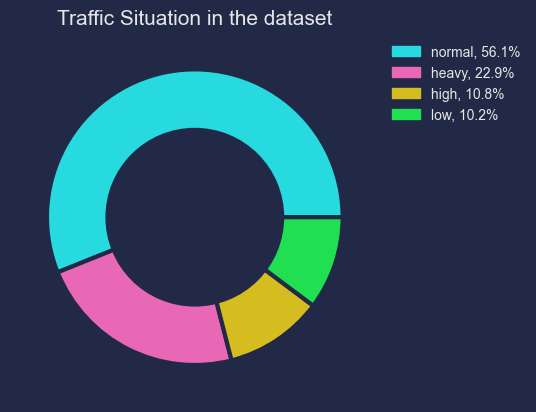

In [19]:
plt.Figure(facecolor="#212946")
ax=plt.axes()
plot_donut_chart(df, 'Traffic Situation', ax, 'Traffic Situation in the dataset')


<AxesSubplot: xlabel='MonthQuarter', ylabel='count'>

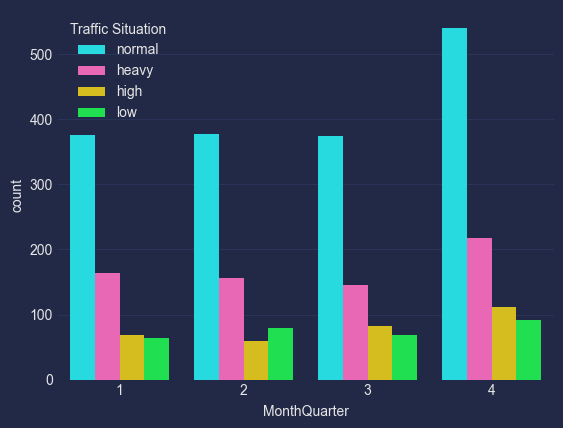

In [20]:
sns.countplot(x = "MonthQuarter" , data=df , hue="Traffic Situation")

#### How it is during the day times ?

<AxesSubplot: xlabel='DaytimeT', ylabel='count'>

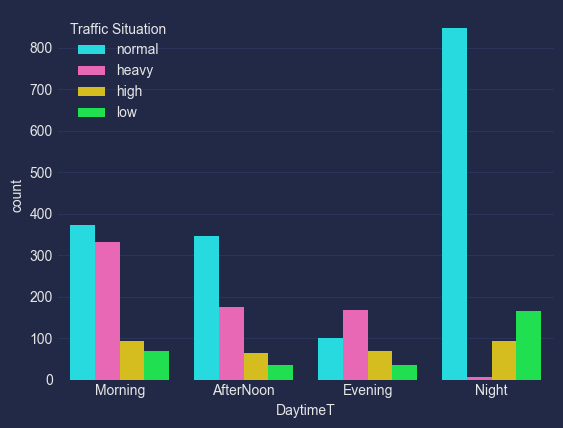

In [21]:
sns.countplot(x="DaytimeT",data=df,hue="Traffic Situation")

#### How is the traffic during the week??

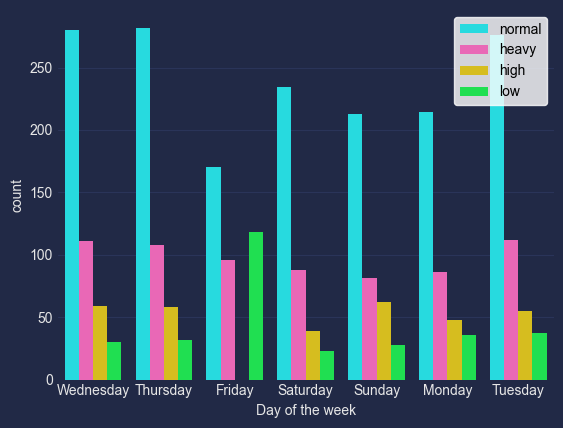

In [22]:
ax=sns.countplot(x="Day of the week",data=df,hue="Traffic Situation")

legend = plt.legend(frameon = 1,labelcolor="black")
frame = legend.get_frame()
frame.set_color('white')

#### Displaying Total counts throughout the month

<AxesSubplot: xlabel='Date', ylabel='Total'>

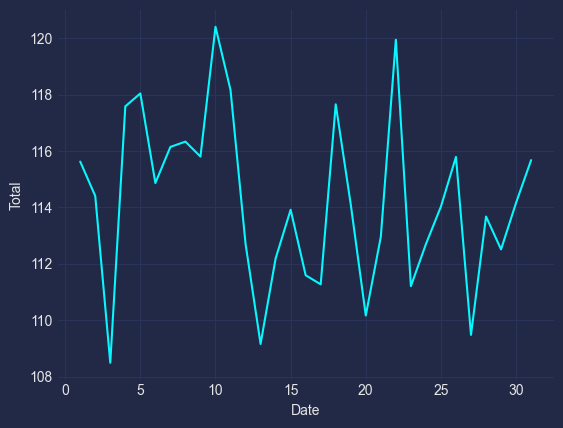

In [23]:
sns.lineplot(data=df,y="Total",x="Date",errorbar=None)

## Modeling

### Droping Unnesscary 

In [24]:
df.drop(["Day of the week","Time","DaytimeT","ModifiedTime"],axis=1,inplace=True)


In [25]:
df.head()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Day,Daytime,MonthQuarter
0,1,97,2,16,7,122,normal,4,1,1
1,1,22,8,31,8,69,normal,4,1,1
2,1,31,23,19,12,85,normal,4,1,1
3,1,49,22,16,5,92,normal,4,1,1
4,1,32,5,3,21,61,normal,4,1,1


In [26]:
df['Traffic Situation'].value_counts()

normal    1669
heavy      682
high       321
low        304
Name: Traffic Situation, dtype: int64

### Encoding

In [27]:
traffic_situation= {
    'low':0,
    'normal':1,
    'high' : 2,
    'heavy' : 3
}

In [28]:
df['Traffic Situation']=df['Traffic Situation'].map(traffic_situation)
df['Traffic Situation'].value_counts()

1    1669
3     682
2     321
0     304
Name: Traffic Situation, dtype: int64

In [29]:
df['Traffic Situation'].value_counts()/df.shape[0]

1    0.560820
3    0.229167
2    0.107863
0    0.102151
Name: Traffic Situation, dtype: float64

In [30]:
X=df.drop(columns='Traffic Situation')
y=df['Traffic Situation']

### Oversampling because of Bias

In [31]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=142,stratify=y_smote)

In [33]:
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [34]:
print(X_train.shape)
print(X_test.shape)

(5340, 9)
(1336, 9)


### Model

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For Logistic Regression:
Training score = 92.0%
Testing score = 91.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       334
           1       0.86      0.78      0.82       334
           2       0.90      0.94      0.92       334
           3       0.98      1.00      0.99       334

    accuracy                           0.91      1336
   macro avg       0.91      0.91      0.91      1336
weighted avg       0.91      0.91      0.91      1336



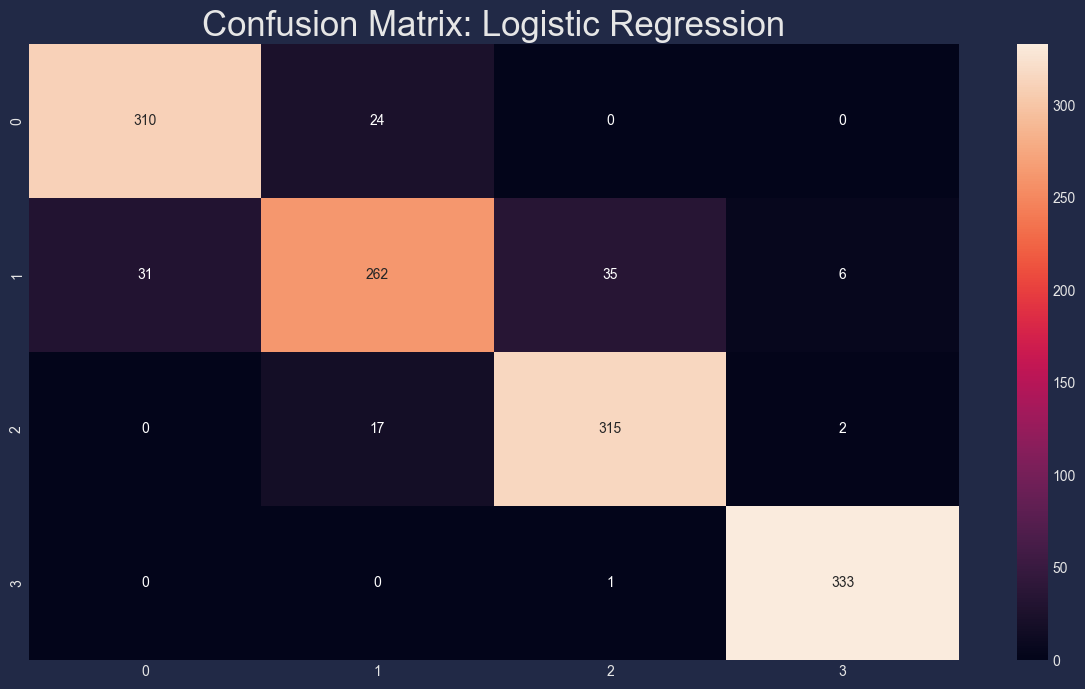

For SVM:
Training score = 93.0%
Testing score = 92.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       334
           1       0.87      0.80      0.83       334
           2       0.90      0.95      0.93       334
           3       0.98      1.00      0.99       334

    accuracy                           0.92      1336
   macro avg       0.92      0.92      0.92      1336
weighted avg       0.92      0.92      0.92      1336



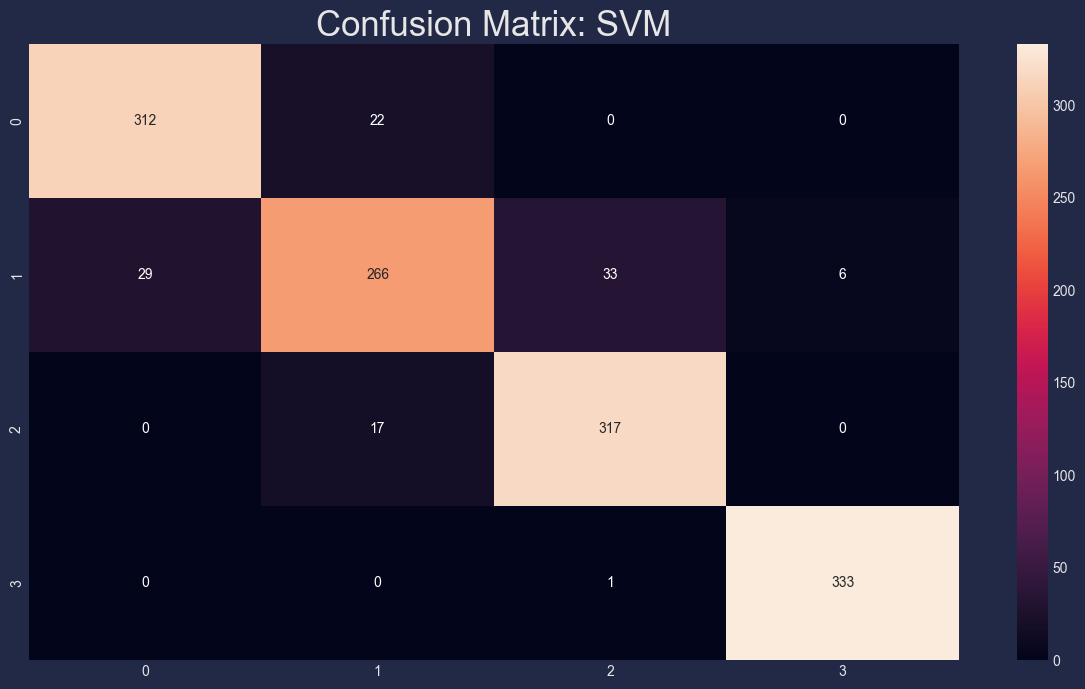

For Decision Tree:
Training score = 100.0%
Testing score = 100.0%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       1.00      0.99      1.00       334
           2       0.99      1.00      1.00       334
           3       1.00      1.00      1.00       334

    accuracy                           1.00      1336
   macro avg       1.00      1.00      1.00      1336
weighted avg       1.00      1.00      1.00      1336



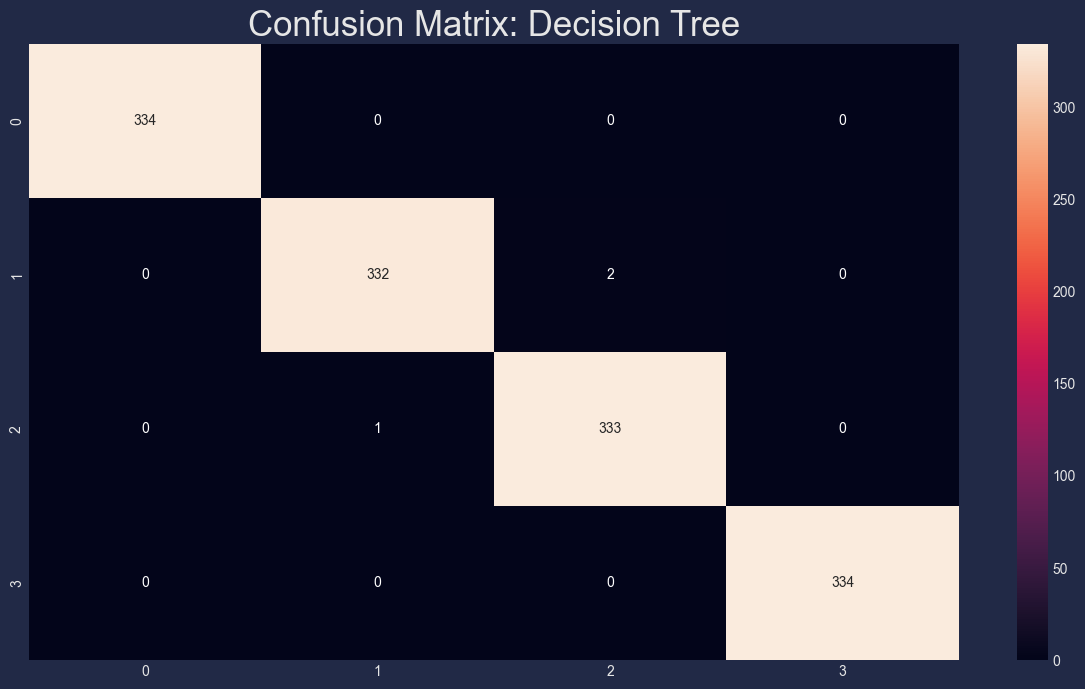

In [35]:
logistic_reg = LogisticRegression(multi_class='multinomial',solver='lbfgs')

svm = SVC(kernel='linear')  # Linear kernel for SVC

decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42)




classifiers = [logistic_reg, svm, decision_tree]
classifier_names = ["Logistic Regression", "SVM", "Decision Tree"]
for clf, name in zip(classifiers, classifier_names):
    
    plt.figure(figsize=(15,8))
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    
    training_score = clf.score(X_train, y_train)
    testing_score = accuracy_score(y_test, y_test_pred)
    
    print(f"For {name}:")
    print(f"Training score = {np.round(training_score * 100, 0)}%")
    print(f"Testing score = {np.round(testing_score * 100, 0)}%")
    print(f"Classification Report:")
    print(classification_report(y_test,y_test_pred))
    sns.heatmap(confusion_matrix(y_test,y_test_pred),annot=True,fmt='g')
    plt.title(f"Confusion Matrix: {name}",fontdict={'size':25})
    plt.show()

[Text(0.5769230769230769, 0.9, 'Total <= 0.771\nentropy = 2.0\nsamples = 5340\nvalue = [1335, 1335, 1335, 1335]\nclass = 0'),
 Text(0.38461538461538464, 0.7, 'Total <= -0.167\nentropy = 1.585\nsamples = 4001\nvalue = [1335, 1331, 1335, 0]\nclass = 0'),
 Text(0.23076923076923078, 0.5, 'TruckCount <= -0.069\nentropy = 0.985\nsamples = 2337\nvalue = [1335, 1002, 0, 0]\nclass = 0'),
 Text(0.15384615384615385, 0.3, 'BusCount <= -0.094\nentropy = 0.33\nsamples = 1421\nvalue = [1335, 86, 0, 0]\nclass = 0'),
 Text(0.07692307692307693, 0.1, 'entropy = 0.0\nsamples = 1335\nvalue = [1335, 0, 0, 0]\nclass = 0'),
 Text(0.23076923076923078, 0.1, 'entropy = 0.0\nsamples = 86\nvalue = [0, 86, 0, 0]\nclass = 1'),
 Text(0.3076923076923077, 0.3, 'entropy = 0.0\nsamples = 916\nvalue = [0, 916, 0, 0]\nclass = 1'),
 Text(0.5384615384615384, 0.5, 'TruckCount <= 0.712\nentropy = 0.717\nsamples = 1664\nvalue = [0, 329, 1335, 0]\nclass = 2'),
 Text(0.46153846153846156, 0.3, 'BusCount <= 0.597\nentropy = 0.961\n

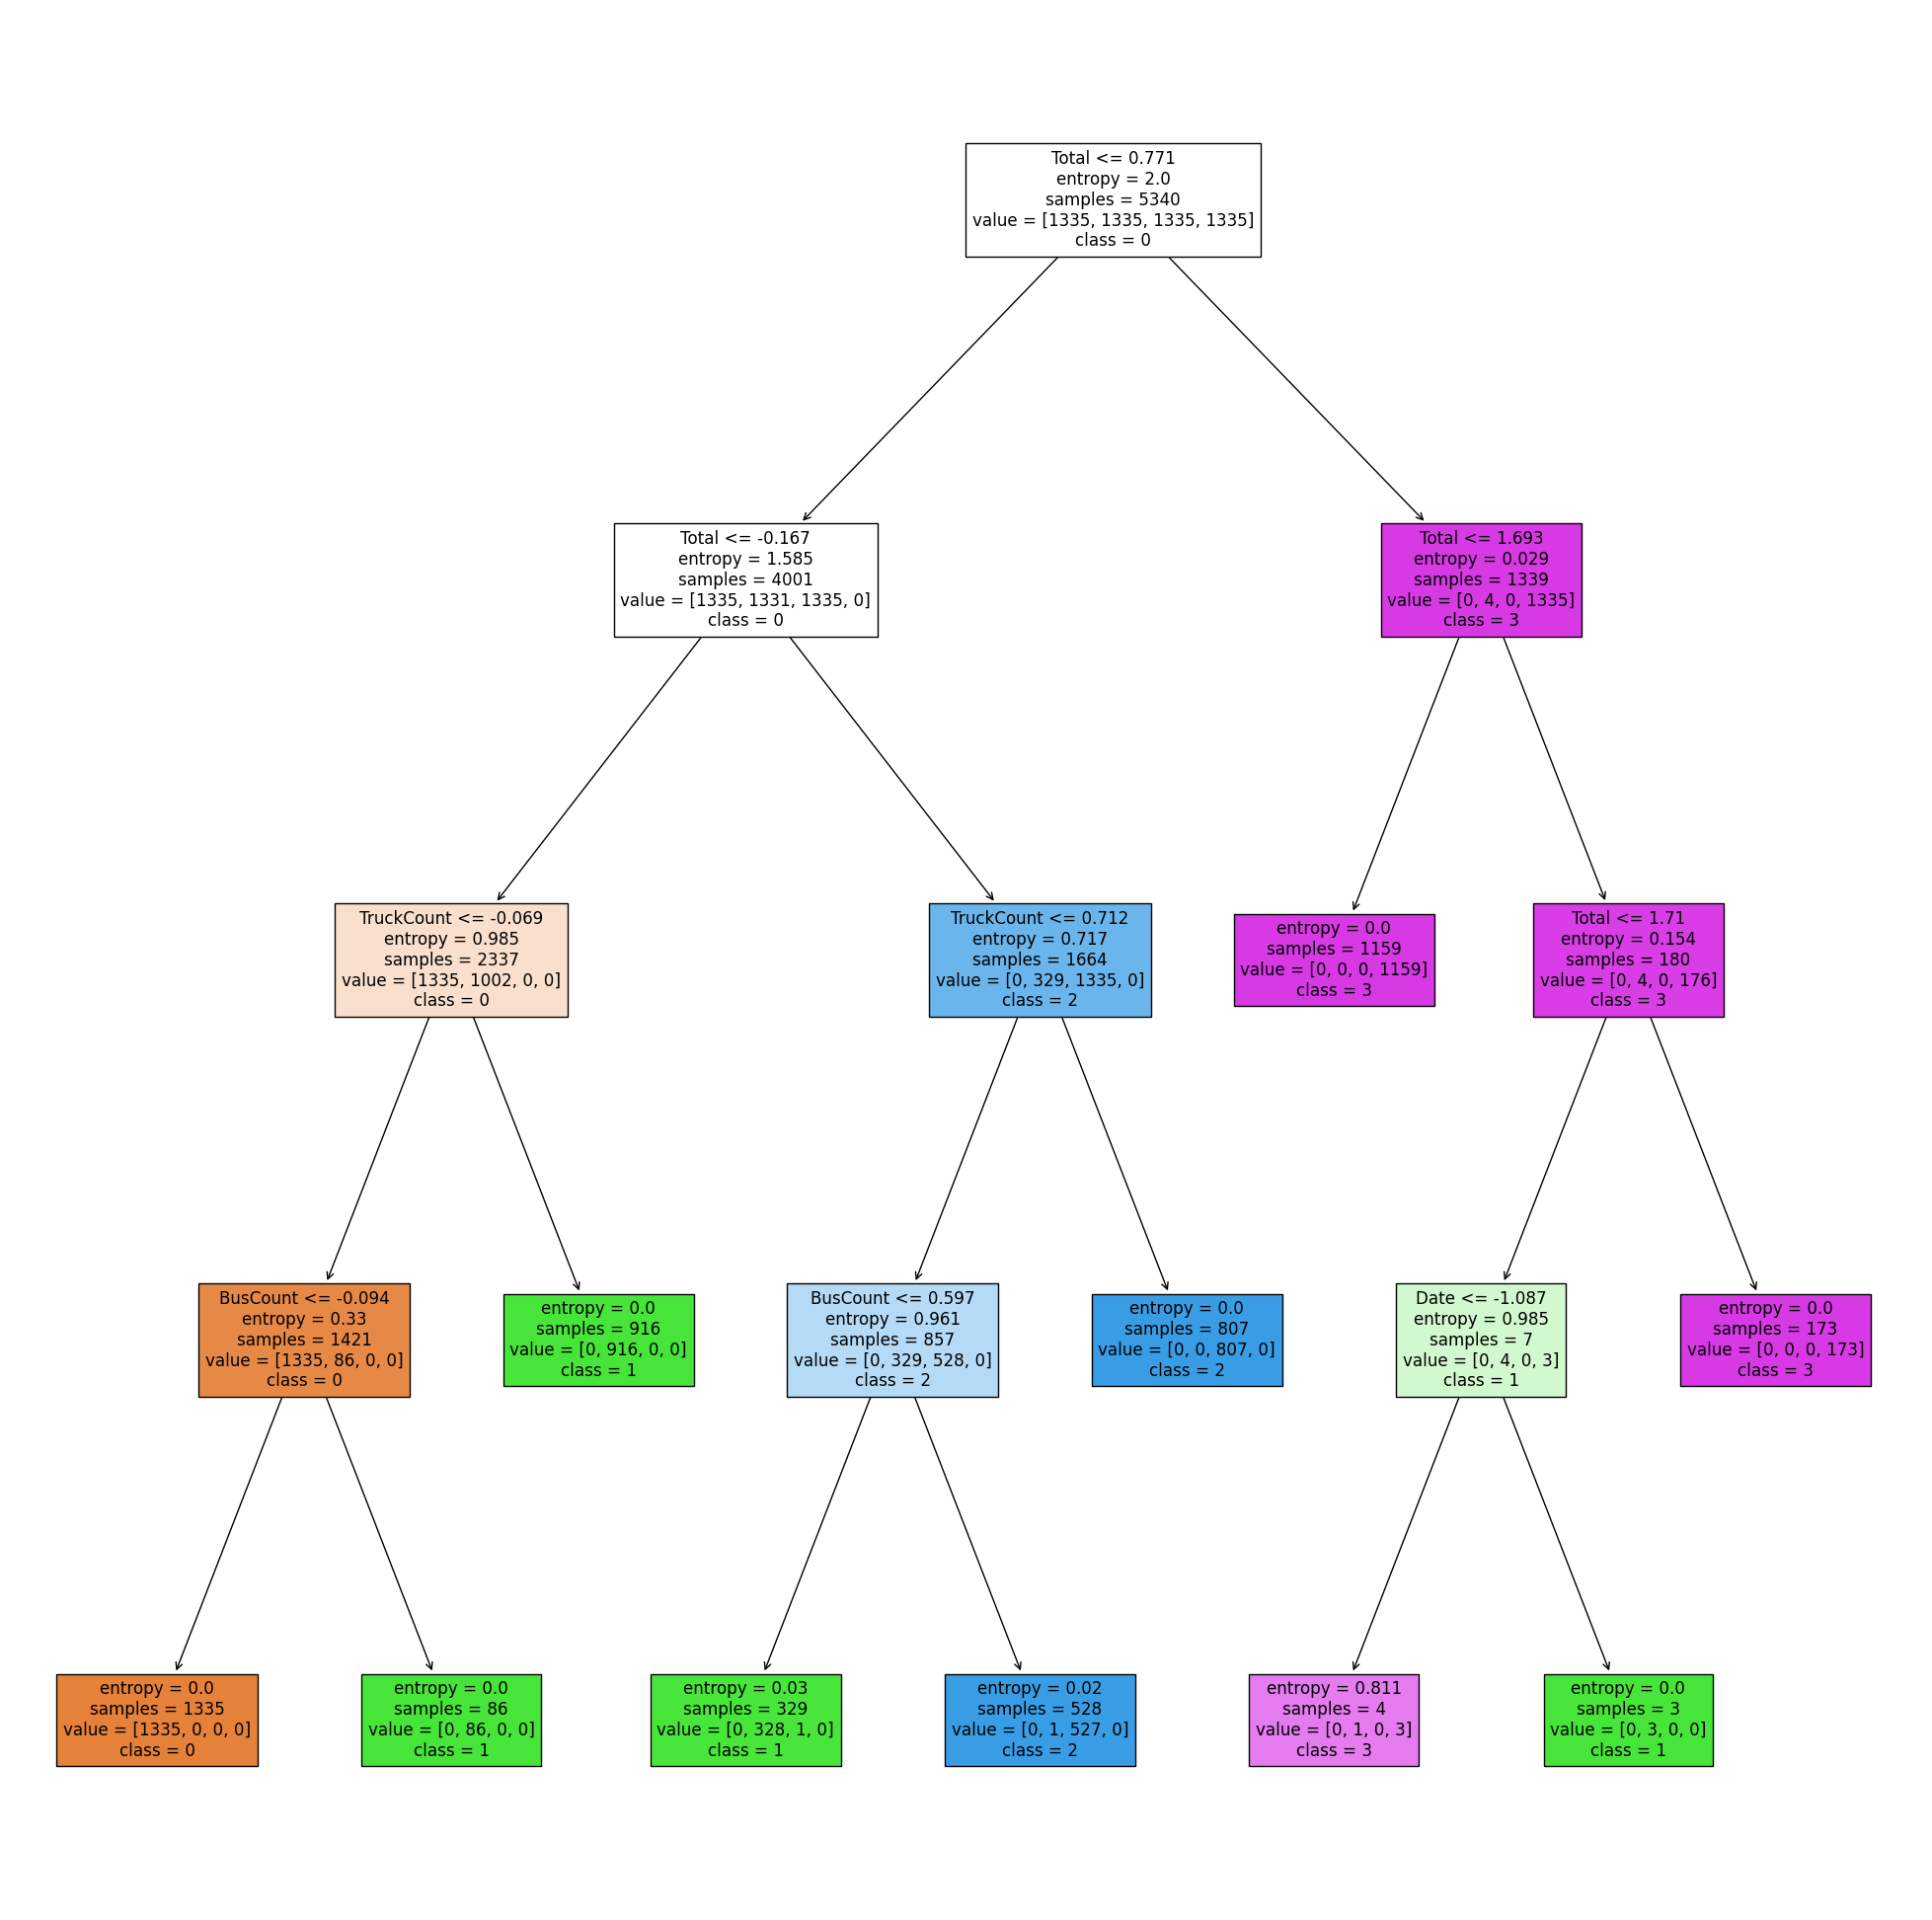

In [36]:
from sklearn import tree
plt.style.use("default")
plt.figure(figsize=(25,25))
tree.plot_tree(decision_tree,feature_names=df.columns,class_names=['0','1','2','3'],filled=True)

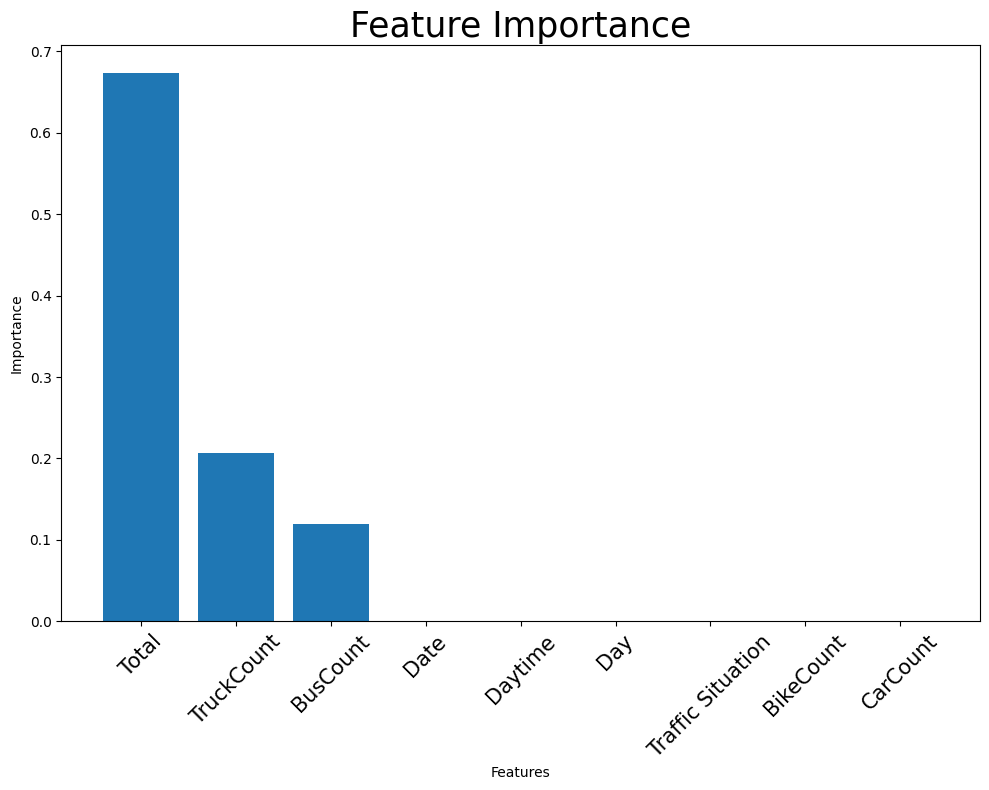

In [37]:
importance = clf.feature_importances_

# Sort feature importance in descending order
indices = importance.argsort()[::-1]

plt.figure(figsize=(10,8))
plt.title("Feature Importance",fontdict={'size':25})
plt.bar(range(len(importance)), importance[indices], align="center")
plt.xticks(range(len(importance)), [df.columns[i] for i in indices], rotation=45,fontdict={'size':15})
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [38]:
y_score= clf.predict_proba(X_test) # Calculating the predicted probability of each class 

In [39]:
n_classes=y.unique() ## Getting the classes of the Y column 

# To binarize the target by one-hot-encoding in a OvR fashion
label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)

y_onehot_test.shape  # (n_samples, n_classes)

(1336, 4)

In [40]:
y_test[:5]

2938    1
1212    1
5382    2
5393    2
111     3
Name: Traffic Situation, dtype: int64

In [41]:
y_onehot_test[:5]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

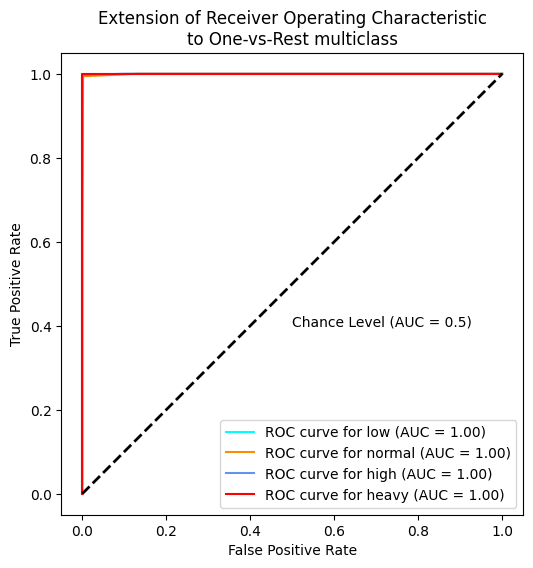

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue","red"])
target_names=list(traffic_situation.keys())

for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        
    )
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.text(0.5, 0.4, 'Chance Level (AUC = 0.5)')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()